In [1]:
#%%
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt

'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x 1
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    tol: tolerance for gradient check
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW_sliced_parallel:
    def __init__(self, mux, M, covx, covM, c0, eta, n_slice, max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0
        self.w = np.zeros([mux.shape[0],1])
        self.I = np.identity(np.size(mux), dtype=np.float64)
        self.n_slice = n_slice
        self.W = np.zeros([mux.size, n_slice])

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0, dtype=np.float64)
        self.mubar = np.zeros_like(mux, dtype=np.float64)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM, dtype=np.float64)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]],dtype=np.float64)
        self.zeta_c = 0
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter], dtype=np.float64)
        self.grads = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        self.weights = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        self.eta = eta
        
    # Method to reset values of variables for new run
    def reset_values(self):
        self.I = np.identity(np.size(self.mux))
        self.w = np.zeros([mux.shape[0], 1])

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                         ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
        
    # Weight initialization method to to start Frank-Wolfe Algorithm
    def initialize_weights(self):
        self.c = self.c0
    # Method to update bar{\mu} = Mc
    def update_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)
    # Sliced MMD objective function
    def compute_mmd_sliced(self):
        return (self.W.T @ (self.M @ self.c[:, np.newaxis] - self.mux))**2
    # Sliced MMD gradient
    def compute_mmd_grad_sliced(self):
        temp = 2 * (self.M.T @ self.W) * np.squeeze(self.W.T @ (self.M @ self.c[:, np.newaxis] - self.mux))
        temp =  temp

        return np.squeeze(temp)
    # Method to compute \tilde{\Sigma_{k}} = \Sigma_{k} + \mu_{k}\mu_{k}^{T} - \bar{\mu} \bar{\mu}^{T}
    def update_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]
    # Method to compute \tilde{\Sigma_{\mathbf{c}}} = \sum_{c} \tilde{\Sigma_{c}}
    def update_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)
    # Method to compute the regularized last part of bures objective, 
    # which is used both in bures objective and its gradient
    # sqrt ( (w.T @ tilde_sigma_c @ w) * (w.T @ covx @ w) + eta^ /4 )
    # This part of the slicing comes from Austin's unpublished paper
    def update_zeta_c(self):
        temp = np.sqrt(np.sum(self.W * (self.tilde_sigma_c @ self.W), axis = 0) * np.sum(self.W * (self.covx @ self.W), axis = 0)  + self.eta**4/4)
        temp = np.real(temp)
        self.zeta_c = temp
   # Regularized and unregulrized sliced Bures objetives
    def compute_bures_sliced(self):
        if self.eta == 0:
            return np.sum(self.W * ((self.tilde_sigma_c + self.covx) @ self.W), axis = 0) - 2 * self.zeta_c
        else:
            B = np.sum(self.W * ((self.tilde_sigma_c + self.covx) @ self.W), axis = 0) - 2 * self.zeta_c
            B = B + self.eta**2 * np.log(2 * self.zeta_c + self.eta**2) 
            B = B + self.covx.shape[0] * self.eta**2 * (1  - np.log(2*self.eta**2))
            return B

    # Bures Gradient with respect to \mathbf{c}
    def compute_bures_grad_c_sliced(self):
        G = 1 -( np.sum(self.W * (self.covx @ self.W), axis = 0) / self.zeta_c) * (1 - self.eta**2/(2*self.zeta_c + self.eta**2))
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0], 1) @ self.mubar.T) + \
            self.mubar @ self.M.T.reshape(self.M.shape[1], 1, self. M.shape[0])

        Grad = G * np.sum(self.W * ((self.hat_covM - rho) @ self.W) , axis = 1 ) 

        return Grad

    # Frechet Objective as sum of bures and MMD objectives
    def compute_frechet_sliced(self):
        B = self.compute_bures_sliced()
        mmd = self.compute_mmd_sliced()
        return B + mmd
    # Frechet gradient as sum of bures and MMD gradients
    def compute_frechet_grad_sliced(self):
        GB = self.compute_bures_grad_c_sliced()
        Gmmd = self.compute_mmd_grad_sliced()
        return GB + Gmmd
    
    # Frank Wolfe Routine for Frechet
    def FW_frechet_routine_sliced(self):
        self.initialize_weights()
        if self.print_iter == True:
            print("initially")
            print(self.c)
        # obj_slice = np.zeros(self.n_slice)
        # grad_slice = np.zeros([self.c0.size, self.n_slice])
        W = np.random.normal(0, 1, [self.covx.shape[0], self.n_slice])
        norm_W = np.linalg.norm(W, axis=0)
        W = W / norm_W[np.newaxis, :]
        self.W = W

        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()

            self.update_zeta_c()
            obj_slice = self.compute_frechet_sliced()
            grad_slice = self.compute_frechet_grad_sliced()

            self.obj_vals[i] = np.mean(obj_slice)
            self.grads[i, :] = np.mean(grad_slice, axis=1)
            g = self.grads[i, :]
            #print(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s

            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter = ", i)
                print(self.c)
    
    # Frank Wolfe Routine for Bures
    def FW_bures_routine_sliced(self):
        self.initialize_weights()
        if self.print_iter == True:
            print("initially")
            print(self.c)
        # obj_slice = np.zeros(self.n_slice)
        # grad_slice = np.zeros([self.c0.size, self.n_slice])
        W = np.random.normal(0, 1, [self.covx.shape[0], self.n_slice])
        norm_W = np.linalg.norm(W, axis=0)
        W = W / norm_W[np.newaxis, :]
        self.W = W

        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()

            self.update_zeta_c()
            obj_slice = self.compute_bures_sliced()
            grad_slice = self.compute_bures_grad_c_sliced()

            self.obj_vals[i] = np.mean(obj_slice)
            self.grads[i, :] = np.mean(grad_slice, axis=1)
            g = self.grads[i, :]
            #print(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s

            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter = ", i)
                print(self.c)
            
    # Frank Wolfe Routine for MMD
    def FW_mmd_routine_sliced(self):
        self.initialize_weights()
        if self.print_iter == True:
            print("initially")
            print(self.c)
        # obj_slice = np.zeros(self.n_slice)
        # grad_slice = np.zeros([self.c0.size, self.n_slice])
        W = np.random.normal(0, 1, [self.covx.shape[0], self.n_slice])
        norm_W = np.linalg.norm(W, axis=0)
        W = W / norm_W[np.newaxis, :]
        self.W = W

        for i in range(0, self.max_iter):
            self.update_mubar()
            obj_slice = self.compute_mmd_sliced()
            grad_slice = self.compute_mmd_grad()

            self.obj_vals[i] = np.mean(obj_slice)
            self.grads[i, :] = np.mean(grad_slice, axis=1)
            g = self.grads[i, :]
            #print(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s

            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter = ", i)
                print(self.c)


def Hellinger(p, q):
  '''
  Function to evaluate Hellinger Distance between distributions categorical distributions p and q
  input: distributions p and q
  outputs: Hillnger distance between p and q

  '''
  assert np.all(p >= 0), "first distribution must be non-negative"
  assert np.all(q >= 0), "second distribution must be non-negative"
  assert p.size == q.size, "input vectors must be of same size"

  p = p.reshape([p.size, 1])
  q = q.reshape([q.size, 1])

  return (1/np.sqrt(2)) * np.linalg.norm(np.sqrt(p) - np.sqrt(q))


In [8]:
import numpy as np
import scipy as sp

M = np.array([[0, -0.5, 0.5],[1, 0, 0]])
#M = np.array([[0, 0, 0], [0, 0, 0]])
#M = np.ones_like(M)
# mux = np.array([[0.5], [0] ])
# covx = np.array([[4,1],[1,2]])
covM = np.zeros([3,2,2])
covM[0] = np.array([[1, 0.5],[0.5, 1]]) 
covM[1] = np.array([[5, 0.6], [0.6, 7]])
covM[2] = np.array([[4, 1], [1, 2]])

mux = np.mean(M, axis = 1, keepdims = True)
#mux = np.array([[1], [1] ])
covx = 1/3 * covM[0] + 1/3 * covM[1] + 1/3 * covM[2]

c0 = np.ones(3)/3
 
iterations = 100

test = GM_FW_sliced_parallel(mux, M, covx, covM, c0, eta = 0.001, n_slice = 100, max_iter = iterations, print_iter = True)
test.reset_values()
test.FW_bures_routine_sliced()
#test.FW_frechet_routine_sliced()
#test.FW_mmd_routine_sliced()
#test.reset_values()

initially
[0.33333333 0.33333333 0.33333333]
iter =  0
[1. 0. 0.]
iter =  1
[0.33333333 0.66666667 0.        ]
iter =  2
[0.66666667 0.33333333 0.        ]
iter =  3
[0.4 0.6 0. ]
iter =  4
[0.6 0.4 0. ]
iter =  5
[0.42857143 0.57142857 0.        ]
iter =  6
[0.57142857 0.42857143 0.        ]
iter =  7
[0.44444444 0.33333333 0.22222222]
iter =  8
[0.35555556 0.26666667 0.37777778]
iter =  9
[0.29090909 0.4        0.30909091]
iter =  10
[0.40909091 0.33333333 0.25757576]
iter =  11
[0.34615385 0.28205128 0.37179487]
iter =  12
[0.43956044 0.24175824 0.31868132]
iter =  13
[0.38095238 0.34285714 0.27619048]
iter =  14
[0.45833333 0.3        0.24166667]
iter =  15
[0.40441176 0.38235294 0.21323529]
iter =  16
[0.47058824 0.33986928 0.18954248]
iter =  17
[0.42105263 0.40935673 0.16959064]
iter =  18
[0.47894737 0.36842105 0.15263158]
iter =  19
[0.43333333 0.33333333 0.23333333]
iter =  20
[0.39393939 0.3030303  0.3030303 ]
iter =  21
[0.35968379 0.36363636 0.27667984]
iter =  22
[0.41304

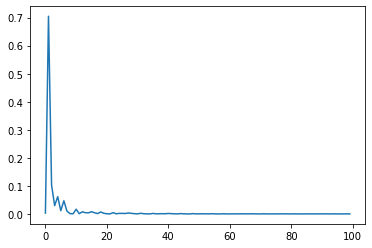

In [3]:
plt.plot(test.obj_vals)


# MNIST

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from numpy.random import exponential
from sklearn.decomposition import PCA
from random import randint
from random import sample
from numpy.random import permutation as permutation
import time
import os

# np.random.seed(2021)

# Data Processing before PCA
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(X_train, y), (X_test, yt) = keras.datasets.mnist.load_data()

X_train = X_train / 255
y = y / 1
X_test = X_test / 255
yt = yt / 1

X = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
Xt = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

from sklearn.decomposition import PCA
pca_components = 130
pca = PCA(n_components = pca_components)
pca.fit(X)
# np.sum(pca.explained_variance_ratio_)
P = pca.components_
X_hat = (X@P.T)
Xt_hat = (Xt@P.T)

n_class = np.size(np.unique(y))
mean_k = np.zeros([n_class, pca_components])
cov_k = np.zeros([n_class, pca_components, pca_components])

# Class Mean and Covariance Computation 
test_class_prev = np.zeros(n_class)
for i in range(0, n_class):
    mean_k[i] = np.mean(X_hat[y == i], axis = 0)
    cov_k[i] = np.cov(X_hat[y == i].T)
    test_class_prev[i] = Xt_hat[yt == i].shape[0]


# N_samples indicates the number of samples to be drawn from data
N_sample = 100
# sample_sz indicates the sample sizes
sample_sz = [50, 100, 200, 300, 400]
#sample_sz = [50]
# Frank-Wolfe Iterations 
FW_iteration = 200

# Varibles to be stored and used later 

Grads = np.zeros([len(sample_sz), N_sample, FW_iteration, n_class])
Optimal_weights = np.zeros([len(sample_sz), N_sample, FW_iteration, n_class])
Sample_distributions = np.zeros([len(sample_sz), N_sample, n_class])
Timer = np.zeros([len(sample_sz), N_sample])

for s_z in range(len(sample_sz)):
    #generating numbers adding
    for sample_iter in range(0, N_sample):
        # Distribution generation for sampling
        # This step is done separately so that we could test extreme cases
        s = n_class * [0]
        s[0] = randint(0,sample_sz[s_z])
        for i in range(1, n_class): 
            if sum(s) < sample_sz[s_z]:
                s[i] = randint(1, sample_sz[s_z] - sum(s[0:i]))
        s = permutation(np.array(s))
        
        # Change the line below depnding on the data set dimensions
        test_sample = np.empty([0, pca_components], dtype = float)
        
        for i in range(0, n_class):
            if s[i] != 0:
                idx = sample(range(0, int(test_class_prev[i])), s[i])
                test_sample = np.append(test_sample, Xt_hat[yt == i][idx], axis = 0)
        tic = time.time()

        mux = (np.mean(test_sample, axis = 0, keepdims = True)).T
        covx = np.cov(test_sample.T)

        M = mean_k.T
        covM = cov_k

        c0 = np.ones(n_class)/n_class
        MNIST = GM_FW_sliced_parallel(mux, M, covx, covM, c0, eta = 1e-1, n_slice = 100, max_iter = FW_iteration, print_iter = False)
        MNIST.FW_frechet_routine_sliced()
        
        toc = time.time()
        Timer[s_z, sample_iter] = toc - tic
        Optimal_weights[s_z, sample_iter] = MNIST.weights
        Grads[s_z, sample_iter] = MNIST.grads
        Sample_distributions[s_z, sample_iter] = np.squeeze(s)
        
        disp = "Sample Size = " + str(sample_sz[s_z]) + " and " + "sample number = " + str(sample_iter) 

        print(disp, end='\r')

from tempfile import TemporaryFile
MNIST_data = TemporaryFile()
np.savez("MNIST_data_Frechet_sliced", Optimal_weights=Optimal_weights, Grads=Grads, Timer=Timer, \
         Sample_distributions=Sample_distributions)


NameError: name 'Time' is not defined

In [12]:
from tempfile import TemporaryFile
MNIST_data = TemporaryFile()
np.savez("MNIST_data_Frechet_sliced", Optimal_weights=Optimal_weights, Grads=Grads, Timer=Timer, \
         Sample_distributions=Sample_distributions)

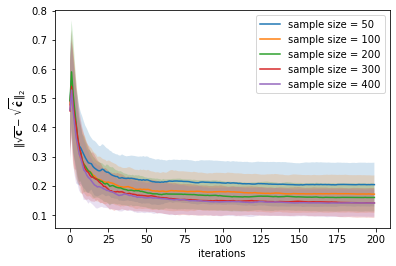

In [13]:
Hellinger_metric = np.zeros([len(sample_sz), N_sample, FW_iteration])
for k in range(len(sample_sz)):
    for i in range(0, N_sample):
        for j in range(0, FW_iteration):
            Hellinger_metric[k, i, j] = Hellinger(Sample_distributions[k,i]/sample_sz[k], Optimal_weights[k,i, j, :])

iters = np.array([k for k in range(0, FW_iteration)])
Hellinger_means = np.mean(Hellinger_metric, axis=1)
Hellinger_std = np.std(Hellinger_metric, axis=1)
#plt.semilogy(iters, (Hellinger_metric.T))
for k in range(0, len(sample_sz)):
    txt = "sample size = " + str(sample_sz[k])
    plt.plot(iters, Hellinger_means[k,:], label = txt)
    plt.fill_between(iters, Hellinger_means[k,:] - Hellinger_std[k,:],
                 Hellinger_means[k,:] + Hellinger_std[k,:], alpha=0.2)
plt.legend()
plt.xlabel("iterations")
plt.ylabel(
    "$\ \Vert \sqrt{\mathbf{c}} - \sqrt{\hat{\mathbf{c}}} \Vert_{2}$")
plt.show()

# CIFAR

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from numpy.random import exponential
from sklearn.decomposition import PCA
from random import randint
from random import sample
from numpy.random import permutation as permutation
import time
import os

from tempfile import TemporaryFile
import pickle

def LoadFile(file_name):
  with open(file_name,'rb') as f:
    data = pickle.load(f)
  return data

# np.random.seed(2021)

# Data Processing before PCA
# tf.keras.datasets.mnist.load_data(path="mnist.npz")
# (X_train, y), (X_test, yt) = keras.datasets.mnist.load_data()

# X_train = X_train / 255
# y = y / 1
# X_test = X_test / 255
# yt = yt / 1

# X = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
# Xt = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


X = LoadFile('x_train_Cifar10_VGG16_512.pkl')
Xt = LoadFile('x_test_Cifar10_VGG16_512.pkl')
y = LoadFile('y_train_Cifar10_VGG16_512.pkl')
yt = LoadFile('y_test_Cifar10_VGG16_512.pkl')
y = np.squeeze(y)
yt = np.squeeze(yt)

n_features = X.shape[1]

# from sklearn.decomposition import PCA
# pca_components = 130
# pca = PCA(n_components = pca_components)
# pca.fit(X)
# # np.sum(pca.explained_variance_ratio_)
# P = pca.components_
# X_hat = (X@P.T)
# Xt_hat = (Xt@P.T)

n_class = np.size(np.unique(y))
mean_k = np.zeros([n_class, n_features])
cov_k = np.zeros([n_class, n_features, n_features])

# # Class Mean and Covariance Computation 
# test_class_prev = np.zeros(n_class)
for i in range(0, n_class):
    mean_k[i] = np.mean(X[y == i], axis = 0)
    cov_k[i] = np.cov(X[y == i].T)
    test_class_prev[i] = Xt[yt == i].shape[0]


# N_samples indicates the number of samples to be drawn from data
N_sample = 100
# sample_sz indicates the sample sizes
sample_sz = [50, 100, 200, 300, 400]
# sample_sz = [50]
# Frank-Wolfe Iterations 
FW_iteration = 200

# # Varibles to be stored and used later 

Grads = np.zeros([len(sample_sz), N_sample, FW_iteration, n_class])
Optimal_weights = np.zeros([len(sample_sz), N_sample, FW_iteration, n_class])
Sample_distributions = np.zeros([len(sample_sz), N_sample, n_class])
Timer = np.zeros([len(sample_sz), N_sample])

for s_z in range(len(sample_sz)):
    #generating numbers adding
    for sample_iter in range(0, N_sample):
        # Distribution generation for sampling
        # This step is done separately so that we could test extreme cases
        s = n_class * [0]
        s[0] = randint(0,sample_sz[s_z])
        for i in range(1, n_class): 
            if sum(s) < sample_sz[s_z]:
                s[i] = randint(1, sample_sz[s_z] - sum(s[0:i]))
        s = permutation(np.array(s))
        
        # Change the line below depnding on the data set dimensions
        test_sample = np.empty([0, n_features], dtype = float)
        
        for i in range(0, n_class):
            if s[i] != 0:
                idx = sample(range(0, int(test_class_prev[i])), s[i])
                test_sample = np.append(test_sample, Xt[yt == i][idx], axis = 0)
        tic = time.time()

        mux = (np.mean(test_sample, axis = 0, keepdims = True)).T
        covx = np.cov(test_sample.T)

        M = mean_k.T
        covM = cov_k

        c0 = np.ones(n_class)/n_class
        CIFAR = GM_FW_sliced_parallel(mux, M, covx, covM, c0, eta = 1e-1, n_slice = 100, max_iter = FW_iteration, print_iter = False)
        CIFAR.FW_frechet_routine_sliced()
        
        toc = time.time()
        Timer[s_z, sample_iter] = toc - tic
        Optimal_weights[s_z, sample_iter] = CIFAR.weights
        Grads[s_z, sample_iter] = CIFAR.grads
        Sample_distributions[s_z, sample_iter] = np.squeeze(s)
        
        disp = "Sample Size = " + str(sample_sz[s_z]) + " and " + "sample number = " + str(sample_iter) 

        print(disp, end='\r')

from tempfile import TemporaryFile
CIFAR10_data = TemporaryFile()
np.savez("CIFAR10_data_Frechet_sliced", Optimal_weights=Optimal_weights, Grads=Grads, \
         Sample_distributions=Sample_distributions, Timer = Timer)


# Fashion-MNIST

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from numpy.random import exponential
from sklearn.decomposition import PCA
from random import randint
from random import sample
from numpy.random import permutation as permutation
import time
import os

from tempfile import TemporaryFile
import pickle

def LoadFile(file_name):
  with open(file_name,'rb') as f:
    data = pickle.load(f)
  return data

# np.random.seed(2021)

# Data Processing before PCA
# tf.keras.datasets.mnist.load_data(path="mnist.npz")
# (X_train, y), (X_test, yt) = keras.datasets.mnist.load_data()

# X_train = X_train / 255
# y = y / 1
# X_test = X_test / 255
# yt = yt / 1

# X = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
# Xt = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


X = LoadFile('x_train_MNIST_Fashion_inception_2048.pkl')
Xt = LoadFile('x_test_MNIST_Fashion_inception_2048.pkl')
y = LoadFile('y_train_MNIST_Fashion_inception_2048.pkl')
yt = LoadFile('y_test_MNIST_Fashion_inception_2048.pkl')
y = np.squeeze(y)
yt = np.squeeze(yt)

n_features = X.shape[1]

# from sklearn.decomposition import PCA
# pca_components = 130
# pca = PCA(n_components = pca_components)
# pca.fit(X)
# # np.sum(pca.explained_variance_ratio_)
# P = pca.components_
# X_hat = (X@P.T)
# Xt_hat = (Xt@P.T)

n_class = np.size(np.unique(y))
mean_k = np.zeros([n_class, n_features])
cov_k = np.zeros([n_class, n_features, n_features])

# # Class Mean and Covariance Computation 
# test_class_prev = np.zeros(n_class)
for i in range(0, n_class):
    mean_k[i] = np.mean(X[y == i], axis = 0)
    cov_k[i] = np.cov(X[y == i].T)
    test_class_prev[i] = Xt[yt == i].shape[0]


# N_samples indicates the number of samples to be drawn from data
N_sample = 100
# sample_sz indicates the sample sizes
sample_sz = [50, 100, 200, 300, 400]
# sample_sz = [50]
# Frank-Wolfe Iterations 
FW_iteration = 200

# # Varibles to be stored and used later 

Grads = np.zeros([len(sample_sz), N_sample, FW_iteration, n_class])
Optimal_weights = np.zeros([len(sample_sz), N_sample, FW_iteration, n_class])
Sample_distributions = np.zeros([len(sample_sz), N_sample, n_class])
Timer = np.zeros([len(sample_sz), N_sample])

for s_z in range(len(sample_sz)):
    #generating numbers adding
    for sample_iter in range(0, N_sample):
        # Distribution generation for sampling
        # This step is done separately so that we could test extreme cases
        s = n_class * [0]
        s[0] = randint(0,sample_sz[s_z])
        for i in range(1, n_class): 
            if sum(s) < sample_sz[s_z]:
                s[i] = randint(1, sample_sz[s_z] - sum(s[0:i]))
        s = permutation(np.array(s))
        
        # Change the line below depnding on the data set dimensions
        test_sample = np.empty([0, n_features], dtype = float)
        
        for i in range(0, n_class):
            if s[i] != 0:
                idx = sample(range(0, int(test_class_prev[i])), s[i])
                test_sample = np.append(test_sample, Xt[yt == i][idx], axis = 0)
        tic = time.time()

        mux = (np.mean(test_sample, axis = 0, keepdims = True)).T
        covx = np.cov(test_sample.T)

        M = mean_k.T
        covM = cov_k

        c0 = np.ones(n_class)/n_class
        FMNIST = GM_FW_sliced_parallel(mux, M, covx, covM, c0, eta = 1e-1, n_slice = 100, max_iter = FW_iteration, print_iter = False)
        FMNIST.FW_frechet_routine_sliced()
        
        toc = time.time()
        Timer[s_z, sample_iter] = toc - tic
        Optimal_weights[s_z, sample_iter] = FMNIST.weights
        Grads[s_z, sample_iter] = FMNIST.grads
        Sample_distributions[s_z, sample_iter] = np.squeeze(s)
        
        disp = "Sample Size = " + str(sample_sz[s_z]) + " and " + "sample number = " + str(sample_iter) 

        print(disp, end='\r')

from tempfile import TemporaryFile
CIFAR10_data = TemporaryFile()
np.savez("FMNIST_data_Frechet_sliced", Optimal_weights=Optimal_weights, Grads=Grads, \
         Sample_distributions=Sample_distributions, Timer = Timer)
